# Monte Carlo Simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Consumerprices from Statistics Norway
# url = 'https://www.ssb.no/en/statbank/sq/10036396' # - index
url = 'https://www.ssb.no/en/statbank/sq/10036397'    # 12-mnth growth
df = pd.read_excel(url, skiprows = 3, skipfooter = 57)
df.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
df.index = df['Date']
df.drop(['Date'], axis = 1, inplace=True)

In [4]:
df.head()

,12-month rate (per cent)
Date,
1991M08,3.7
1991M09,3.3
1991M10,2.5
1991M11,2.5
1991M12,2.8


<table>
    
$$Net\ present\ value = -Investment + \frac{Cashflow_{t+1}}{(1+r)^1} + \frac{Cashflow_{t+2}}{(1+r)^2} + \frac{Cashflow_{t+3}}{(1+r)^3} $$
          
</table>

In [5]:
mu = df['12-month rate (per cent)'].mean()/100
sigma = df['12-month rate (per cent)'].std()/100

mu, sigma

(0.02091428571428571, 0.009842517640309079)

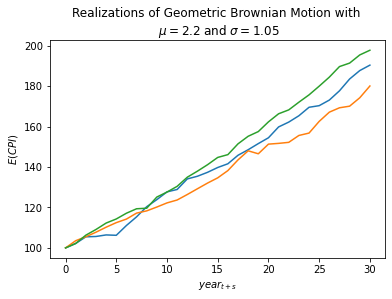

In [6]:
# source: https://en.wikipedia.org/wiki/Geometric_Brownian_motion 

n = 30 # Years
dt = 1 #time period
x0 = 100
np.random.seed(8)

#  Sigma low
x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T
)

x = np.vstack([np.ones(1), x])
x = x0 * x.cumprod(axis=0)

#  New draw
y = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T
)

y = np.vstack([np.ones(1), y])
y = x0 * y.cumprod(axis=0)

#  New draw
z = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T
)

z = np.vstack([np.ones(1), z])
z = x0 * z.cumprod(axis=0)

#  Sigma high
u = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T
)

u = np.vstack([np.ones(1), u])
u = x0 * u.cumprod(axis=0)


# plt.plot(np.log(x))
plt.plot(x)
plt.plot(y)
plt.plot(z)

# plt.legend(np.round(sigma, 2))
plt.xlabel("$year_{t+s}$")
plt.ylabel("$E(CPI)$")
plt.title(
    "Realizations of Geometric Brownian Motion with \n $\mu=2.2$ and $\sigma=1.05$"
)
# plt.show()
# Uncomment to save the image
plt.savefig('Figures/brownian.png', dpi=600)

In [21]:
mu, sigma

(0.021978082191780813, 0.010545795560516753)

In [7]:
import numpy_financial as npf

ModuleNotFoundError: No module named 'numpy_financial'

In [8]:
x = x.T
cashflows = np.random.normal(100, 10, size=(1, n+1))
nominalCashflows = cashflows*x/100

In [9]:
investment = -1000

nominalCashflows = list(nominalCashflows.flatten()) 
nominalCashflows[0]=0

In [10]:
rate = 0.05
# NPV = 
np.round(npf.npv(rate, nominalCashflows)+ investment,5)



242.85829

In [10]:
x = list(x.flatten())

In [11]:
df = pd.DataFrame(index=range(len(nominalCashflows)), data={'C': nominalCashflows, 'CPI':x})

df.head()

,C,CPI
0,0.000000,100.000000
1,111.109266,102.314816
2,103.351523,105.793111
3,105.244664,105.940279
4,104.490223,106.716720


In [18]:
avg = mu
std_dev = sigma
num_reps = 500
num_simulations = 10000

# Define a list to keep all the results from each simulation that we want to analyze
all_npv = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose inputs
    n = 15 # Years
    dt = 1 #time period
    x0 = 100
    num = 1
    num = num+i  # seed increases with one for every simulation
    np.random.seed(num)
#     caluculate cashflow using the geometric brownian motion formula: 
    x = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T)

    x = np.vstack([np.ones(1), x])
    x = x0 * x.cumprod(axis=0)
    x = list(x.flatten())
# choose distibution    
    cashflows = np.random.normal(100, 10, size=(1, n+1))
#     cashflows = np.random.poisson(100, size=(n+1))
    nominalCashflows = cashflows*x/100
    investment = -1150
    nominalCashflows = list(nominalCashflows.flatten()) 
    nominalCashflows[0]=0

    
    # Calculate NPV
    NPV = np.round(npf.npv(rate, nominalCashflows)+ investment,5)
    
    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(1), data={ 'NPV':NPV})
    
    # We want to track NPV calculations over all the simulations
    all_npv.append([df['NPV'].sum()])


In [19]:
cashflows

array([[100.90989839,  84.51145354,  99.55172644, 115.56763329,
        119.47110681,  92.14859886,  78.60788062,  87.35741465,
        102.94987179, 108.06489267, 102.77670317,  87.56154958,
        107.87274373, 107.52030412, 101.72980014,  92.62164352]])

In [20]:
results_df = pd.DataFrame.from_records(all_npv, columns=['NPV'])
results_df.head()

,NPV
0,60.21714
1,-12.36821
2,38.04575
3,74.75188
4,99.91849


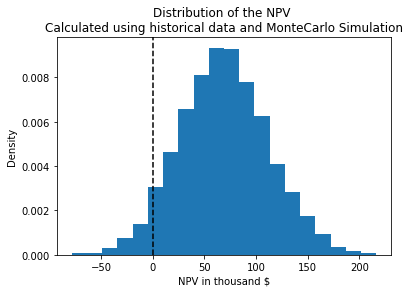

In [21]:
# add a 'best fit' line

plt.hist(results_df['NPV'], 20,  density=True)
plt.title('Distribution of the NPV \nCalculated using historical data and MonteCarlo Simulation')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('NPV in thousand $')
plt.ylabel('Density')
plt.savefig('Figures/NPVMonteCarlo.png')
plt.show()

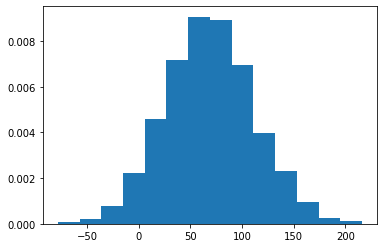

In [22]:
count, bins, ignored = plt.hist(results_df['NPV'], 14, density=True)
plt.show()